In [1]:
!pip install -U -q PyDrive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [49]:
import joblib
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import StackingClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [5]:
!mkdir data

In [6]:
file_id = '1KiOvhsdjJqaUCLJa5adZXEtQ_72s8Eb6'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data/checking-logs.sqlite')

In [7]:
conn = sqlite3.connect('data/checking-logs.sqlite')

In [8]:
df = pd.io.sql.read_sql(
    """
    select uid, labname, numTrials, timestamp
    from checker
    where uid like 'user_%' and status = 'ready'
    """,
    conn, parse_dates=['timestamp']
    )

In [9]:
conn.close()

In [10]:
df['hour'] = df['timestamp'].dt.hour
dayofweek = df['timestamp'].dt.dayofweek
df = df.drop('timestamp', axis=1)

In [11]:
df = pd.get_dummies(df, prefix=['uid', 'labname'], columns=['uid', 'labname'])

In [12]:
df['dayofweek'] = dayofweek

In [13]:
df.head()

,numTrials,hour,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,uid_user_15,uid_user_16,uid_user_17,uid_user_18,uid_user_19,uid_user_2,uid_user_20,uid_user_21,uid_user_22,uid_user_23,uid_user_24,uid_user_25,uid_user_26,uid_user_27,uid_user_28,uid_user_29,uid_user_3,uid_user_30,uid_user_31,uid_user_4,uid_user_6,uid_user_7,uid_user_8,labname_code_rvw,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1,dayofweek
0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
1,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
2,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
3,4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
4,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('dayofweek', axis=1), df['dayofweek'],
    test_size=0.2, random_state=21, stratify=df['dayofweek']
    )

In [15]:
svc = SVC(C=10, gamma='auto', probability=True, random_state=21)

In [16]:
svc.fit(X_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=21, shrinking=True, tol=0.001,
    verbose=False)

In [17]:
y_pred = svc.predict(X_test)

In [18]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.5f}")

Accuracy: 0.88757
Precision: 0.89267
Recall: 0.88757


In [19]:
tree = DecisionTreeClassifier(max_depth=27, class_weight='balanced',
                              random_state=21)

In [20]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=27, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=21, splitter='best')

In [21]:
y_pred = tree.predict(X_test)

In [22]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.5f}")

Accuracy: 0.90237
Precision: 0.90360
Recall: 0.90237


In [23]:
forest = RandomForestClassifier(n_estimators=50, max_depth=28, random_state=21)

In [24]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=28, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [25]:
y_pred = forest.predict(X_test)

In [26]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.5f}")

Accuracy: 0.92899
Precision: 0.93009
Recall: 0.92899


In [37]:
voting_clf = VotingClassifier(
    [('svc', svc), ('tree', tree), ('forest', forest)]
    )

In [38]:
y_pred = voting_clf.fit(X_train, y_train).predict(X_test)

In [39]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.5f}")

Accuracy: 0.92604
Precision: 0.92757
Recall: 0.92604


In [40]:
voting_clf = VotingClassifier(
    [('svc', svc), ('tree', tree), ('forest', forest)], voting='soft'
    )

In [41]:
y_pred = voting_clf.fit(X_train, y_train).predict(X_test)

In [42]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.5f}")

Accuracy: 0.92308
Precision: 0.92388
Recall: 0.92308


In [50]:
weights_list = list(product(range(1, 6), repeat=3))

In [52]:
best_score = 0
best_weights = [0, 0, 0]

for weights in tqdm(weights_list):
    voting_clf = VotingClassifier(
        [('svc', svc), ('tree', tree), ('forest', forest)],
        voting='soft', weights=weights, n_jobs=-1
    )
    y_pred = voting_clf.fit(X_train, y_train).predict(X_test)
    score = accuracy_score(y_test, y_pred)
    if score >= best_score:
        best_score = score
        best_weights = weights

voting_clf = VotingClassifier(
    [('svc', svc), ('tree', tree), ('forest', forest)],
    voting='soft', weights=best_weights, n_jobs=-1
    )

y_pred = voting_clf.fit(X_train, y_train).predict(X_test)

print(f"Best weights: {best_weights}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.5f}")


Best weights: (5, 4, 5)
Accuracy: 0.93195
Precision: 0.93286
Recall: 0.93195


In [53]:
best_score = 0
best_n_estimators = 5

for n_estimators in tqdm([5, 10, 50, 100]):
    bagging_clf = BaggingClassifier(
        base_estimator=SVC(C=10, gamma='auto', probability=True,
                           random_state=21),
        n_estimators=n_estimators, n_jobs=-1, random_state=21
        )
    y_pred = bagging_clf.fit(X_train, y_train).predict(X_test)
    score = accuracy_score(y_test, y_pred)
    if score >= best_score:
        best_score = score
        best_n_estimators = n_estimators

bagging_clf = BaggingClassifier(
    base_estimator=SVC(C=10, gamma='auto', probability=True, random_state=21),
    n_estimators=best_n_estimators, n_jobs=-1, random_state=21
    )

y_pred = bagging_clf.fit(X_train, y_train).predict(X_test)

print(f"Best n_estimators: {best_n_estimators}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.5f}")


Best n_estimators: 100
Accuracy: 0.90828
Precision: 0.91091
Recall: 0.90828


In [55]:
stacking_clf = StackingClassifier(
    [('svc', svc), ('tree', tree), ('forest', forest)]
    )

In [58]:
param_grid = {'cv': [2, 3, 4, 5, 6, 7],
              'passthrough': [True, False]}

cv = GridSearchCV(stacking_clf, param_grid, scoring='accuracy', n_jobs=-1)

In [59]:
cv.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=None, error_score=nan,
             estimator=StackingClassifier(cv=None,
                                          estimators=[('svc',
                                                       SVC(C=10,
                                                           break_ties=False,
                                                           cache_size=200,
                                                           class_weight=None,
                                                           coef0=0.0,
                                                           decision_function_shape='ovr',
                                                           degree=3,
                                                           gamma='auto',
                                                           kernel='rbf',
                                                           max_iter=-1,
                                                           probability=True,
                             

In [60]:
cv.best_params_

{'cv': 4, 'passthrough': True}

In [63]:
y_pred = cv.best_estimator_.predict(X_test)

In [64]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.5f}")

Accuracy: 0.93195
Precision: 0.93364
Recall: 0.93195


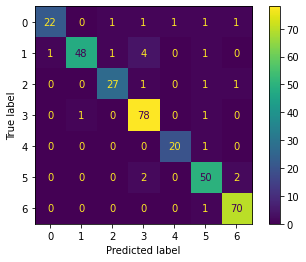

In [65]:
plot_confusion_matrix(cv.best_estimator_, X_test, y_test)
plt.show()

In [66]:
joblib.dump(cv.best_estimator_, 'model.joblib')

['model.joblib']